### K-means vs DBSCAN: Wholesale Customers Dataset Analysis

A comprehensive clustering analysis comparing K-means and DBSCAN algorithms on the UCI Wholesale Customers Dataset. This project performs customer segmentation to identify distinct purchasing patterns and provide actionable business insights.

**Dataset**: The data set refers to clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on different product categories i.e., Fresh, Milk, Grocery, Frozen, Detergents_Paper, Delicassen; plus Channel/Region information.


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy import stats
from scipy.stats import kruskal
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

# Configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Constants
SPENDING_COLS = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
CATEGORICAL_COLS = ['Channel', 'Region']
CHANNEL_MAP = {1: 'Horeca', 2: 'Retail'} #Channel - Horeca (Hotel/Restaurant/CafÃ©) or Retail channel (Nominal)
REGION_MAP = {1: 'Lisbon', 2: 'Oporto', 3: 'Other'} #Region - Lisbon, Oporto or Other (Nominal)

print("Libraries imported successfully!")


Libraries imported successfully!


## Part A: Data Loading & Preprocessing


In [32]:
# Load the dataset
df = pd.read_csv('dataset/Wholesale-customers-data.csv')

print("Dataset loaded successfully!")
print(f"\nDataset shape: {df.shape}")
print(f"\nFirst 10 rows:")
print(df.head(10))


Dataset loaded successfully!

Dataset shape: (440, 8)

First 10 rows:
   Channel  Region  Fresh   Milk  Grocery  Frozen  Detergents_Paper  \
0        2       3  12669   9656     7561     214              2674   
1        2       3   7057   9810     9568    1762              3293   
2        2       3   6353   8808     7684    2405              3516   
3        1       3  13265   1196     4221    6404               507   
4        2       3  22615   5410     7198    3915              1777   
5        2       3   9413   8259     5126     666              1795   
6        2       3  12126   3199     6975     480              3140   
7        2       3   7579   4956     9426    1669              3321   
8        1       3   5963   3648     6192     425              1716   
9        2       3   6006  11093    18881    1159              7425   

   Delicassen  
0        1338  
1        1776  
2        7844  
3        1788  
4        5185  
5        1451  
6         545  
7        2566  
8   

In [29]:
# Show column types and basic info
print("Column types:")
print(df.dtypes)
print("\n" + "_"*50)
print("\nDataset info:")
print(df.info())
print("\n" + "_"*50)
print("\nBasic statistics:")
print(df.describe())


Column types:
Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

__________________________________________________

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB
None

__________________________________________________

Basic statistics:
          Channel      Regio

In [33]:
# Handle missing data
print("Missing values per column:")
missing = df.isnull().sum()
print(missing)
print(f"\nTotal missing values: {missing.sum()}")

if missing.sum() > 0:
    print("\nStrategy: Missing values detected. We will:")
    print("1. For numeric columns: Use median imputation")
    print("2. For categorical columns: Use mode imputation")
    # Uncomment if needed:
    # from sklearn.impute import SimpleImputer
    # numeric_imputer = SimpleImputer(strategy='median')
    # categorical_imputer = SimpleImputer(strategy='most_frequent')
else:
    print("\nNo missing values found. No imputation needed.")


Missing values per column:
Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

Total missing values: 0

No missing values found. No imputation needed.


In [34]:
# Remove exact duplicates
initial_shape = df.shape
print(f"Initial dataset shape: {initial_shape}")

df_clean = df.drop_duplicates()
final_shape = df_clean.shape
print(f"After removing duplicates: {final_shape}")
print(f"Duplicates removed: {initial_shape[0] - final_shape[0]}")

df = df_clean.copy()
print(f"\nFinal dataset dimensions: {df.shape[0]} rows × {df.shape[1]} columns")


Initial dataset shape: (440, 8)
After removing duplicates: (440, 8)
Duplicates removed: 0

Final dataset dimensions: 440 rows × 8 columns


In [35]:
# Helper function for outlier detection using IQR method
def detect_outliers_iqr(data, columns, iqr_multiplier=1.5):
    
    #Detect outliers using IQR method and return counts.
    outlier_info = {}
    for col in columns:
        Q1, Q3 = data[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower = Q1 - iqr_multiplier * IQR
        upper = Q3 + iqr_multiplier * IQR
        mask = (data[col] < lower) | (data[col] > upper)
        outlier_info[col] = {'count': mask.sum(), 'pct': mask.mean() * 100}
    return outlier_info

# Check for outliers
print("Outlier detection using IQR method (values beyond 1.5*IQR):")
outlier_info = detect_outliers_iqr(df, SPENDING_COLS)
for col, info in outlier_info.items():
    print(f"{col}: {info['count']} outliers ({info['pct']:.2f}%)")

# Scale features using RobustScaler (robust to outliers)
scaler = RobustScaler()
df_scaled = df.copy()
df_scaled[SPENDING_COLS] = scaler.fit_transform(df[SPENDING_COLS])

print("\nNumeric features scaled using RobustScaler (robust to outliers)")
print("\nScaled data sample:")
print(df_scaled[SPENDING_COLS].head())


Outlier detection using IQR method (values beyond 1.5*IQR):
Fresh: 20 outliers (4.55%)
Milk: 28 outliers (6.36%)
Grocery: 24 outliers (5.45%)
Frozen: 43 outliers (9.77%)
Detergents_Paper: 30 outliers (6.82%)
Delicassen: 27 outliers (6.14%)

Numeric features scaled using RobustScaler (robust to outliers)

Scaled data sample:
      Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicassen
0  0.301680  1.065712  0.329952 -0.466572          0.506787    0.263810
1 -0.104810  1.092934  0.565993  0.083926          0.675670    0.574008
2 -0.155802  0.915816  0.344418  0.312589          0.736512    4.871459
3  0.344850 -0.429714 -0.062862  1.734708         -0.084442    0.582507
4  1.022092  0.315171  0.287260  0.849573          0.262056    2.988314


In [36]:
# Encode Channel and Region for interpretation (not used in clustering)
df['Channel_label'] = df['Channel'].map(CHANNEL_MAP)
df['Region_label'] = df['Region'].map(REGION_MAP)

print("Channel encoding:")
print(df['Channel'].value_counts().sort_index())
print("\nRegion encoding:")
print(df['Region'].value_counts().sort_index())
print("\nChannel and Region encoded for interpretation only")
print("Note: These categorical features are NOT included in clustering distance calculations")


Channel encoding:
Channel
1    298
2    142
Name: count, dtype: int64

Region encoding:
Region
1     77
2     47
3    316
Name: count, dtype: int64

Channel and Region encoded for interpretation only
Note: These categorical features are NOT included in clustering distance calculations


## Part B: First Exploratory Data Analysis


In [37]:
# Descriptive statistics for spending categories
print("Descriptive Statistics for Spending Categories:")
print("_"*65)
print(df[SPENDING_COLS].describe())


Descriptive Statistics for Spending Categories:
_________________________________________________________________
               Fresh          Milk       Grocery        Frozen  \
count     440.000000    440.000000    440.000000    440.000000   
mean    12000.297727   5796.265909   7951.277273   3071.931818   
std     12647.328865   7380.377175   9503.162829   4854.673333   
min         3.000000     55.000000      3.000000     25.000000   
25%      3127.750000   1533.000000   2153.000000    742.250000   
50%      8504.000000   3627.000000   4755.500000   1526.000000   
75%     16933.750000   7190.250000  10655.750000   3554.250000   
max    112151.000000  73498.000000  92780.000000  60869.000000   

       Detergents_Paper    Delicassen  
count        440.000000    440.000000  
mean        2881.493182   1524.870455  
std         4767.854448   2820.105937  
min            3.000000      3.000000  
25%          256.750000    408.250000  
50%          816.500000    965.500000  
75%        

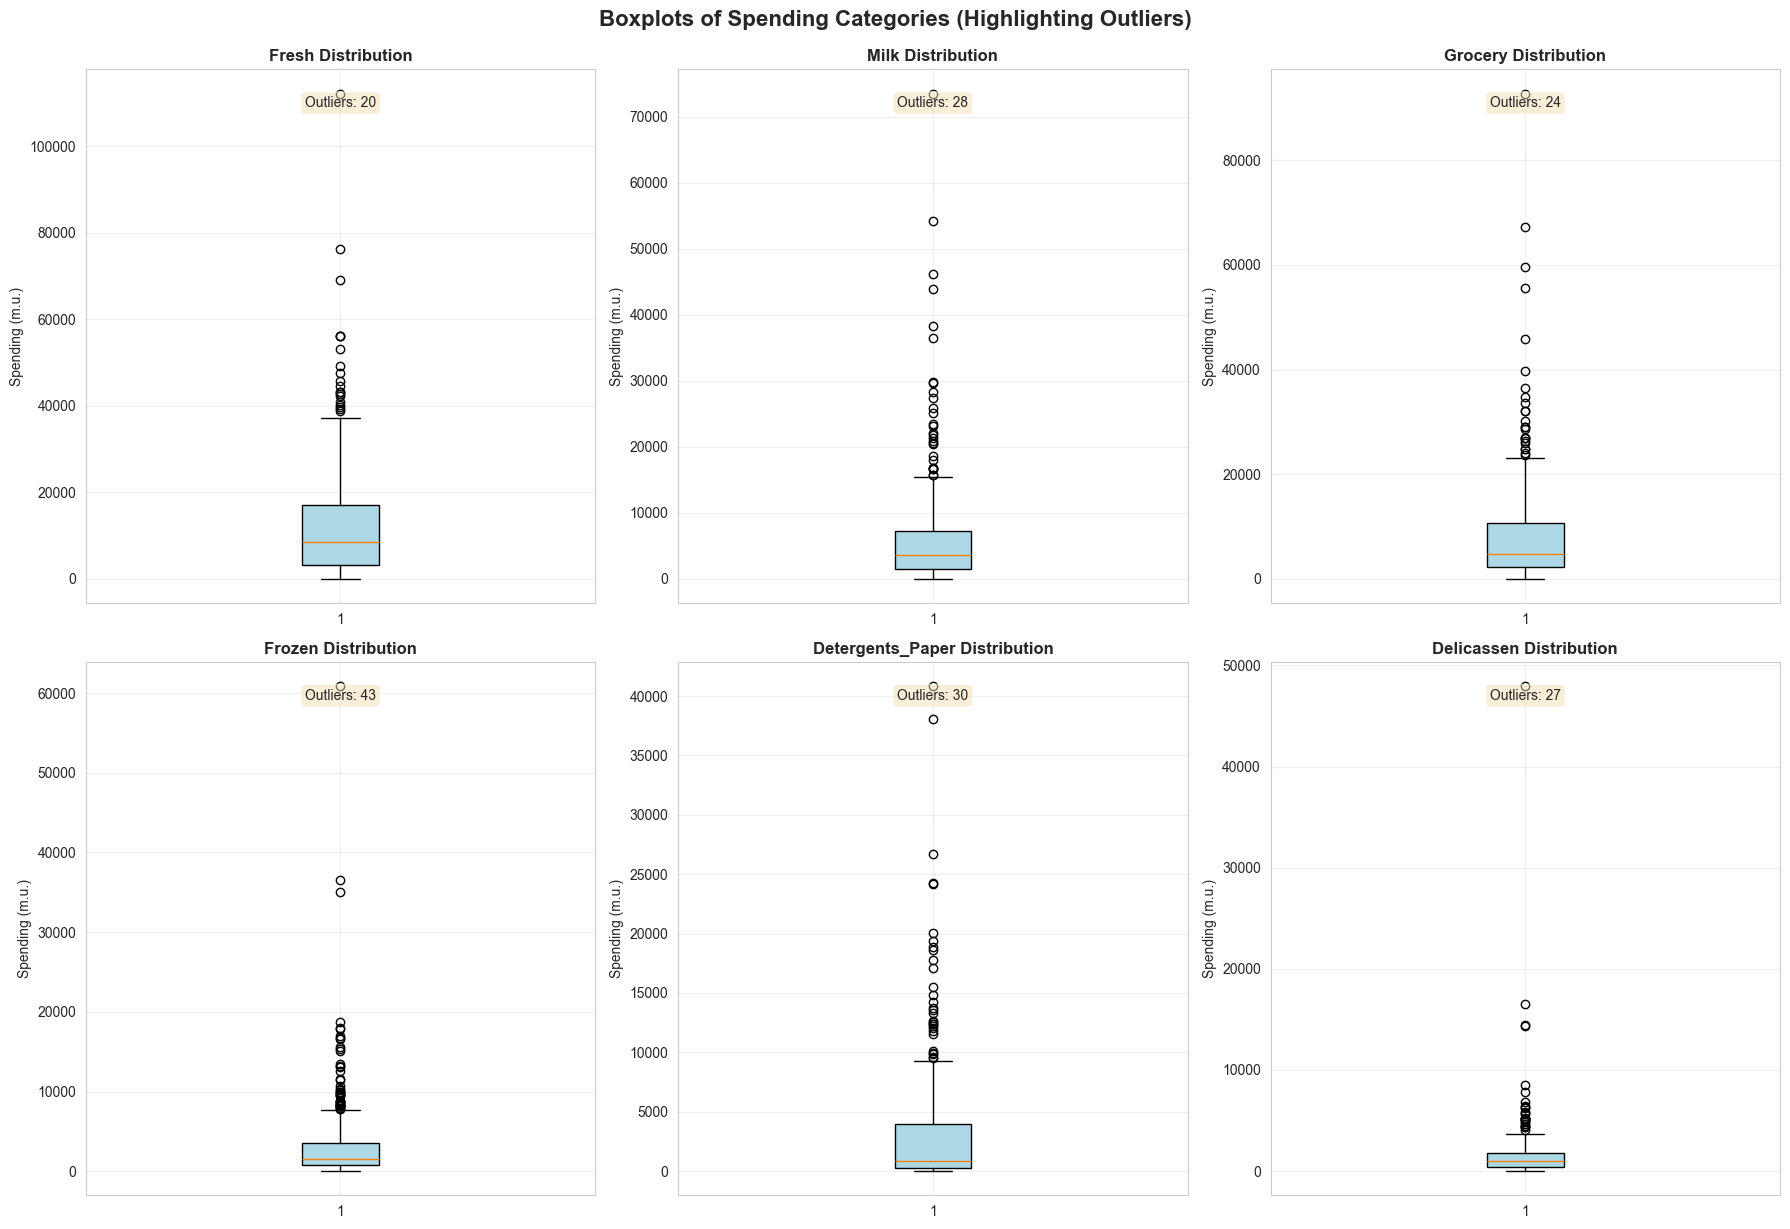


Outlier Summary:
__________________________________________________
Fresh               :  20 outliers ( 4.55%)
Milk                :  28 outliers ( 6.36%)
Grocery             :  24 outliers ( 5.45%)
Frozen              :  43 outliers ( 9.77%)
Detergents_Paper    :  30 outliers ( 6.82%)
Delicassen          :  27 outliers ( 6.14%)

Total outlier instances across all categories: 172


In [38]:
# Create boxplots for spending categories
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, col in enumerate(SPENDING_COLS):
    ax = axes[idx]
    box = ax.boxplot(df[col], vert=True, patch_artist=True)
    box['boxes'][0].set_facecolor('lightblue')
    ax.set_title(f'{col} Distribution', fontsize=12, fontweight='bold')
    ax.set_ylabel('Spending (m.u.)')
    ax.grid(True, alpha=0.3)
    
    # Add outlier count annotation
    outlier_count = outlier_info[col]['count']
    ax.text(0.5, 0.95, f'Outliers: {outlier_count}', 
            transform=ax.transAxes, ha='center', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.suptitle('Boxplots of Spending Categories (Highlighting Outliers)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Summary of outliers
print("\nOutlier Summary:")
print("_"*50)
total_outliers = sum(info['count'] for info in outlier_info.values())
for col, info in outlier_info.items():
    print(f"{col:20s}: {info['count']:3d} outliers ({info['pct']:5.2f}%)")
print(f"\nTotal outlier instances across all categories: {total_outliers}")


In [39]:
# Check skewness and identify highly skewed variables
print("Skewness before log transformation:")
print("_"*35)
skewness_before = df[SPENDING_COLS].skew()
for col, skew in skewness_before.items():
    print(f"{col:20s}: {skew:7.3f}")

# Identify highly skewed variables (|skewness| > 1)
highly_skewed = skewness_before[abs(skewness_before) > 1].index.tolist()
print(f"\nHighly skewed variables (|skewness| > 1): {highly_skewed}")

# Log transform highly skewed variables
df_log = df.copy()
if highly_skewed:
    for col in highly_skewed:
        df_log[f'Log_{col}'] = np.log1p(df[col])
    print(f"\nLog-transformed variables: {[f'Log_{col}' for col in highly_skewed]}")
else:
    print("\nNo highly skewed variables found.")


Skewness before log transformation:
___________________________________
Fresh               :   2.561
Milk                :   4.054
Grocery             :   3.587
Frozen              :   5.908
Detergents_Paper    :   3.632
Delicassen          :  11.152

Highly skewed variables (|skewness| > 1): ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

Log-transformed variables: ['Log_Fresh', 'Log_Milk', 'Log_Grocery', 'Log_Frozen', 'Log_Detergents_Paper', 'Log_Delicassen']


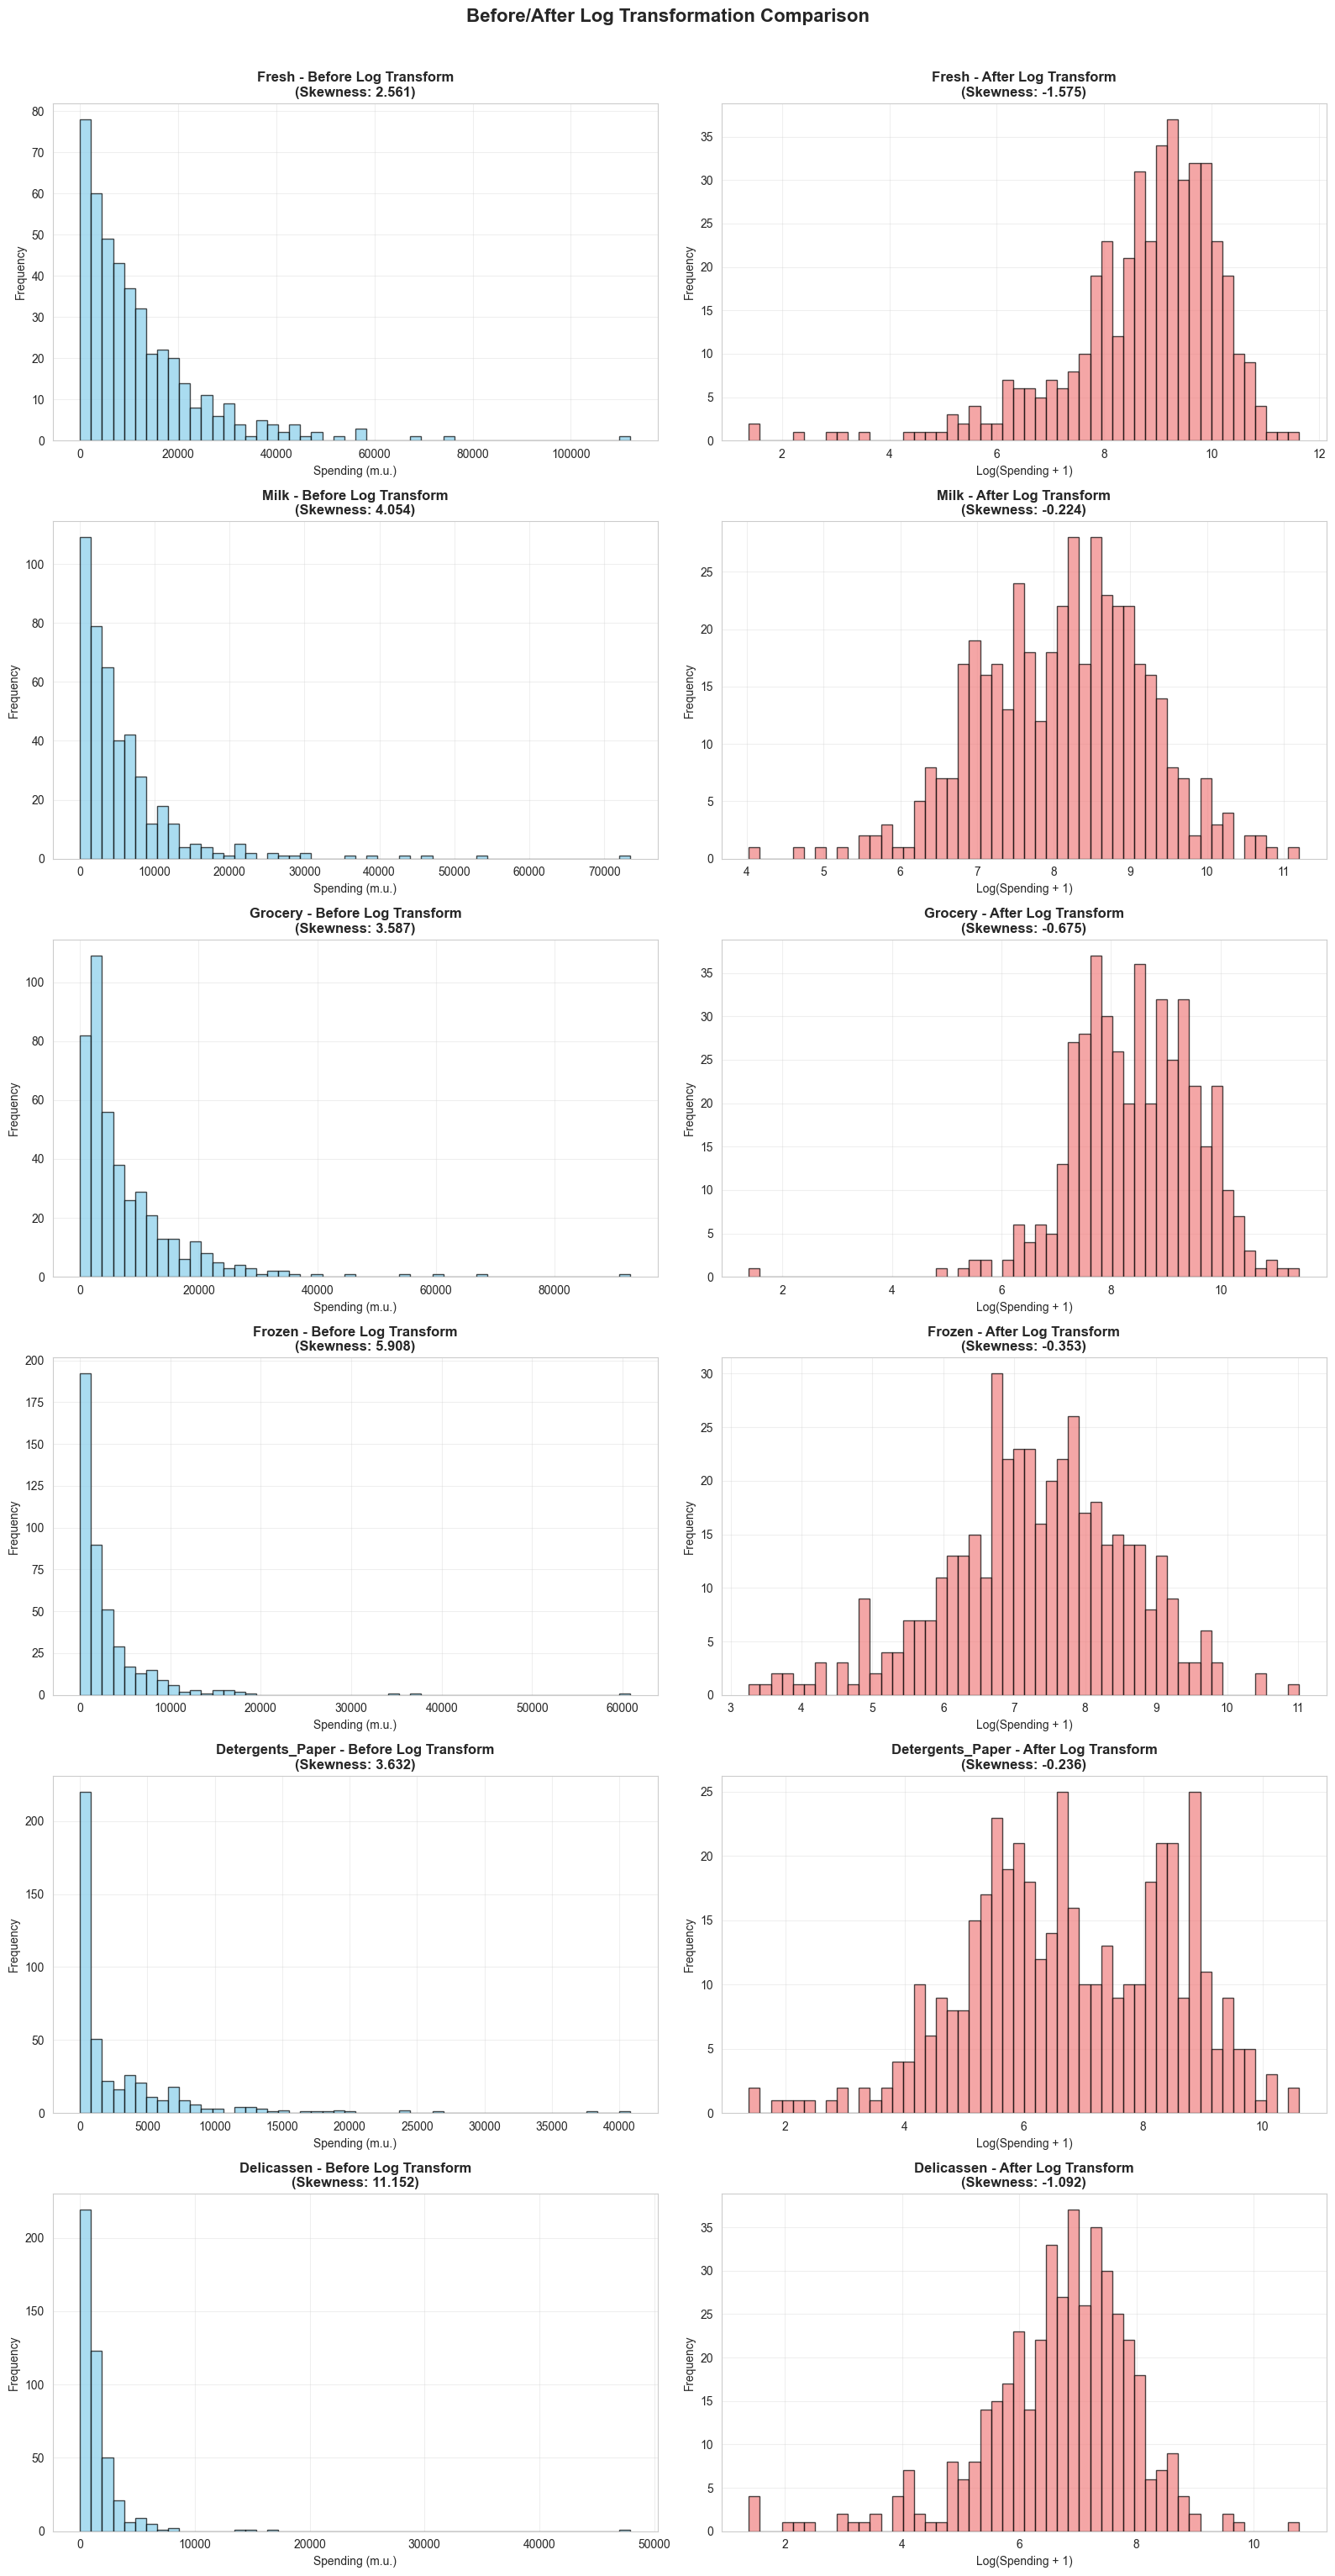


Skewness after log transformation:
________________________________________
Log_Fresh                :  -1.575
Log_Milk                 :  -0.224
Log_Grocery              :  -0.675
Log_Frozen               :  -0.353
Log_Detergents_Paper     :  -0.236
Log_Delicassen           :  -1.092


In [40]:
# Show before/after histograms for log-transformed variables
n_skewed = len(highly_skewed)
if n_skewed > 0:
    fig, axes = plt.subplots(n_skewed, 2, figsize=(16, 5*n_skewed))
    if n_skewed == 1:
        axes = axes.reshape(1, -1)
    
    for idx, col in enumerate(highly_skewed):
        # Before transformation
        axes[idx, 0].hist(df[col], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
        axes[idx, 0].set_title(f'{col} - Before Log Transform\n(Skewness: {skewness_before[col]:.3f})', 
                              fontweight='bold')
        axes[idx, 0].set_xlabel('Spending (m.u.)')
        axes[idx, 0].set_ylabel('Frequency')
        axes[idx, 0].grid(True, alpha=0.3)
        
        # After transformation
        log_col = f'Log_{col}'
        skew_after = df_log[log_col].skew()
        axes[idx, 1].hist(df_log[log_col], bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
        axes[idx, 1].set_title(f'{col} - After Log Transform\n(Skewness: {skew_after:.3f})', 
                              fontweight='bold')
        axes[idx, 1].set_xlabel('Log(Spending + 1)')
        axes[idx, 1].set_ylabel('Frequency')
        axes[idx, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Before/After Log Transformation Comparison', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.show()
    
    print("\nSkewness after log transformation:")
    print("_"*40)
    for col in highly_skewed:
        log_col = f'Log_{col}'
        print(f"{log_col:25s}: {df_log[log_col].skew():7.3f}")
else:
    print("No highly skewed variables found. Log transformation not needed.")


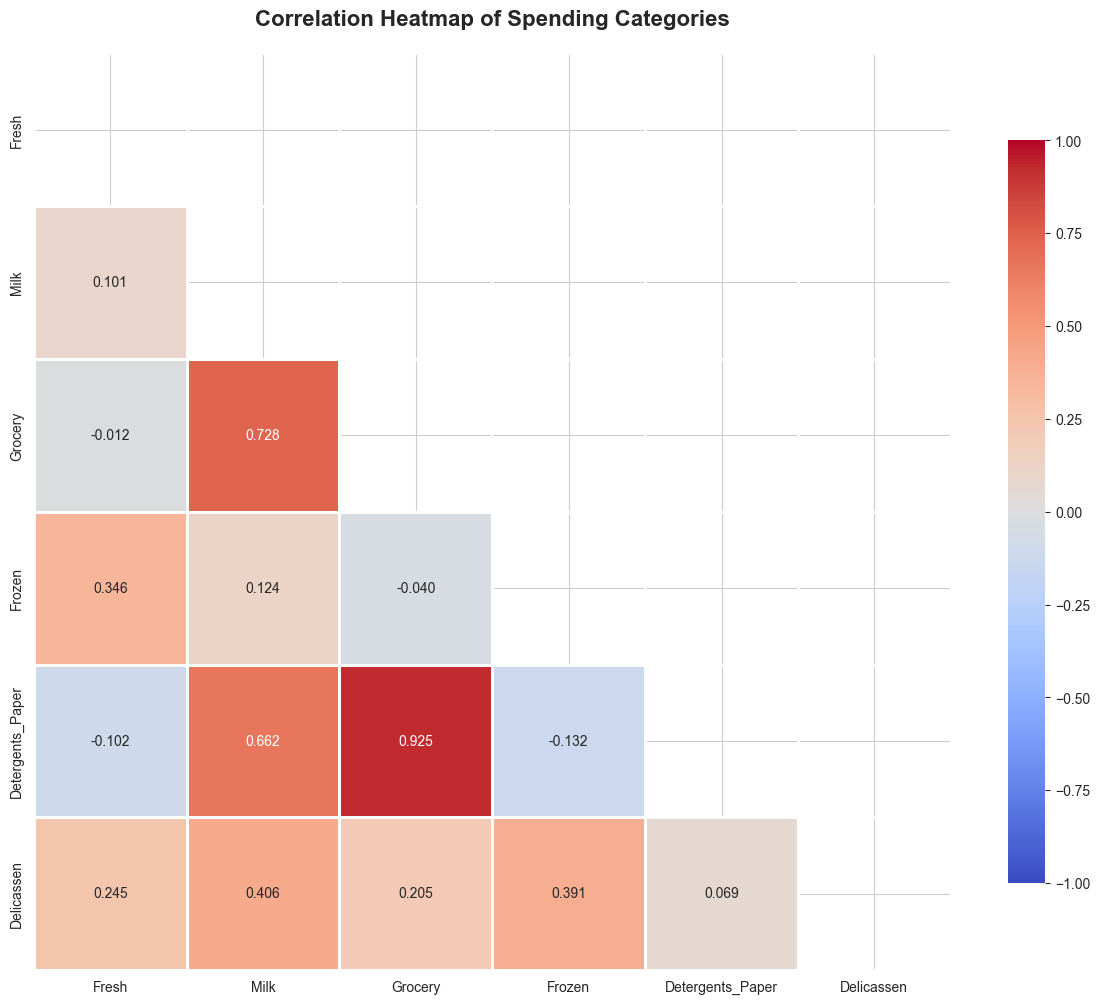


Co-purchasing Pattern Analysis:
________________________________________________________________________________

Strong correlations (|r| > 0.5) indicate co-purchasing patterns:
  Grocery              ↔ Detergents_Paper    :  0.925
  Milk                 ↔ Grocery             :  0.728
  Milk                 ↔ Detergents_Paper    :  0.662

Key Insights:
  • High correlation suggests customers who buy one category also buy the other
  • This can inform cross-selling strategies and inventory management


In [41]:
# Correlation heatmap of spending categories
correlation_matrix = df[SPENDING_COLS].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Spending Categories', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Analyze co-purchasing patterns
print("\nCo-purchasing Pattern Analysis:")
print("_"*80)
print("\nStrong correlations (|r| > 0.5) indicate co-purchasing patterns:")

# Extract strong correlations efficiently
strong_corr = []
for i, col1 in enumerate(SPENDING_COLS):
    for col2 in SPENDING_COLS[i+1:]:
        corr_val = correlation_matrix.loc[col1, col2]
        if abs(corr_val) > 0.5:
            strong_corr.append((col1, col2, corr_val))

if strong_corr:
    for col1, col2, corr in sorted(strong_corr, key=lambda x: abs(x[2]), reverse=True):
        print(f"  {col1:20s} ↔ {col2:20s}: {corr:6.3f}")
else:
    print("  No strong correlations found (|r| > 0.5)")

print("\nKey Insights:")
print("  • High correlation suggests customers who buy one category also buy the other")
print("  • This can inform cross-selling strategies and inventory management")


## Part C: Feature Engineering & Aggregation


In [43]:
# Create derived features efficiently
df_features = df.copy()

# Feature 1: TotalSpend
df_features['TotalSpend'] = df[SPENDING_COLS].sum(axis=1)

# Feature 2: ProportionFresh
df_features['ProportionFresh'] = df['Fresh'] / df_features['TotalSpend']

# Feature 3: LogTotalSpend
df_features['LogTotalSpend'] = np.log1p(df_features['TotalSpend'])

# Feature 4: GroceryMilkRatio
df_features['GroceryMilkRatio'] = df['Grocery'] / (df['Milk'] + 1)

# Feature 5: NonFreshProportion
df_features['NonFreshProportion'] = 1 - df_features['ProportionFresh']

# Display feature statistics
features_info = {
    'TotalSpend': ('sum of all spending categories', 'm.u.'),
    'ProportionFresh': ('Fresh / TotalSpend', ''),
    'LogTotalSpend': ('log(1 + TotalSpend)', ''),
    'GroceryMilkRatio': ('Grocery / (Milk + 1)', ''),
    'NonFreshProportion': ('1 - ProportionFresh', '')
}

print("Feature Engineering Summary:")
print("_"*50)
for feat, (desc, unit) in features_info.items():
    values = df_features[feat]
    print(f"\n{feat}: {desc}")
    print(f"   Range: {values.min():.2f} - {values.max():.2f} {unit}")
    print(f"   Mean: {values.mean():.2f} {unit}")

print("\n" + "_"*50)
print("Feature Engineering Complete!")


Feature Engineering Summary:
__________________________________________________

TotalSpend: sum of all spending categories
   Range: 904.00 - 199891.00 m.u.
   Mean: 33226.14 m.u.

ProportionFresh: Fresh / TotalSpend
   Range: 0.00 - 0.95 
   Mean: 0.38 

LogTotalSpend: log(1 + TotalSpend)
   Range: 6.81 - 12.21 
   Mean: 10.17 

GroceryMilkRatio: Grocery / (Milk + 1)
   Range: 0.00 - 21.02 
   Mean: 1.82 

NonFreshProportion: 1 - ProportionFresh
   Range: 0.05 - 1.00 
   Mean: 0.62 

__________________________________________________
Feature Engineering Complete!


### Justification for Derived Features:

1. **TotalSpend**: Captures overall customer value and spending capacity. Essential for segmenting high-value vs low-value customers.

2. **ProportionFresh**: Reveals customer preference for fresh vs processed products. Helps identify customer segments with different product preferences.

3. **LogTotalSpend**: Normalizes the highly skewed total spending distribution, making it more suitable for clustering algorithms that assume normal distributions.

4. **GroceryMilkRatio**: Identifies customers who prefer grocery items over milk products, useful for product mix optimization.

5. **NonFreshProportion**: Complements ProportionFresh by focusing on processed/frozen products, important for supply chain planning.


## Part D: Clustering Modelling & Parameter Selection


In [44]:
# Prepare data for clustering (use scaled spending features only)
X_cluster = df_scaled[SPENDING_COLS].values
print(f"Data shape for clustering: {X_cluster.shape}")
print("Using scaled spending features only (Channel/Region excluded from distance calculations)")


Data shape for clustering: (440, 6)
Using scaled spending features only (Channel/Region excluded from distance calculations)


### K-means Clustering


In [46]:
# K-means: Test k from 2 to 8
k_range = range(2, 9)
results = []

print("K-means Clustering Results:")
print("_"*70)
print(f"{'k':<5} {'Silhouette Score':<20} {'Davies-Bouldin Index':<25} {'Inertia':<15}")
print("-"*70)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_cluster)
    
    # Calculate metrics
    sil_score = silhouette_score(X_cluster, labels)
    db_score = davies_bouldin_score(X_cluster, labels)
    inertia = kmeans.inertia_
    
    results.append({
        'k': k,
        'silhouette': sil_score,
        'davies_bouldin': db_score,
        'inertia': inertia,
        'model': kmeans
    })
    
    print(f"{k:<5} {sil_score:<20.4f} {db_score:<25.4f} {inertia:<15.2f}")

print("="*70)
print("\nNote:")
print("  • Higher Silhouette Score = better separation")
print("  • Lower Davies-Bouldin Index = better separation")
print("  • Lower Inertia = tighter clusters (but may overfit)")

# Extract metrics for visualization
silhouette_scores = [r['silhouette'] for r in results]
db_scores = [r['davies_bouldin'] for r in results]
inertias = [r['inertia'] for r in results]
kmeans_models = {r['k']: r['model'] for r in results}


K-means Clustering Results:
______________________________________________________________________
k     Silhouette Score     Davies-Bouldin Index      Inertia        
----------------------------------------------------------------------
2     0.9032               0.0647                    4189.88        
3     0.5533               0.8728                    3156.19        
4     0.5153               0.8670                    2509.75        
5     0.3611               0.8636                    2070.29        
6     0.3597               0.8396                    1731.98        
7     0.3624               0.8079                    1444.51        
8     0.3084               0.9312                    1298.50        

Note:
  • Higher Silhouette Score = better separation
  • Lower Davies-Bouldin Index = better separation
  • Lower Inertia = tighter clusters (but may overfit)


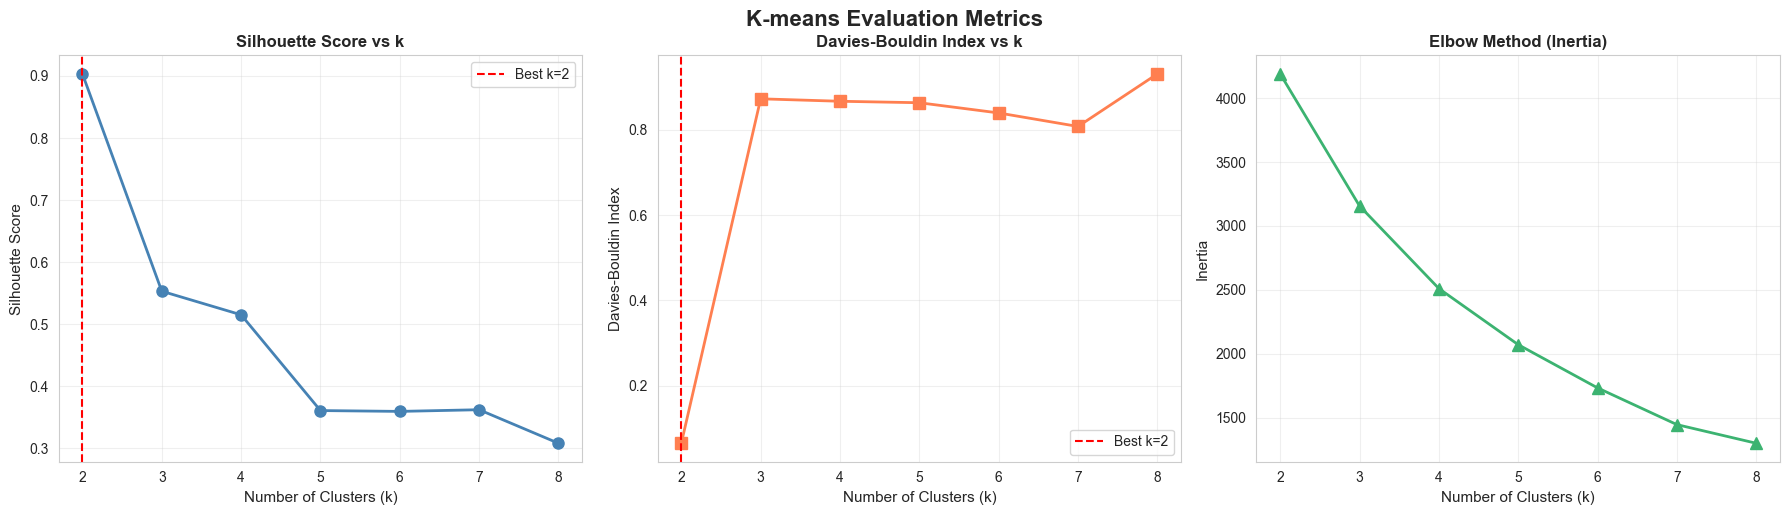


Optimal k based on Silhouette Score: 2 (score: 0.9032)
Optimal k based on Davies-Bouldin Index: 2 (score: 0.0647)

✓ Selected k = 2 (both metrics agree)

K-means clustering complete with k=2
Cluster distribution:
KMeans_Cluster
0    439
1      1
Name: count, dtype: int64


In [47]:
# Visualize K-means evaluation metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Silhouette Score
axes[0].plot(k_range, silhouette_scores, marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[0].set_ylabel('Silhouette Score', fontsize=11)
axes[0].set_title('Silhouette Score vs k', fontweight='bold', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=k_range[np.argmax(silhouette_scores)], color='red', 
                linestyle='--', label=f'Best k={k_range[np.argmax(silhouette_scores)]}')
axes[0].legend()

# Davies-Bouldin Index
axes[1].plot(k_range, db_scores, marker='s', linewidth=2, markersize=8, color='coral')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[1].set_ylabel('Davies-Bouldin Index', fontsize=11)
axes[1].set_title('Davies-Bouldin Index vs k', fontweight='bold', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=k_range[np.argmin(db_scores)], color='red', 
                linestyle='--', label=f'Best k={k_range[np.argmin(db_scores)]}')
axes[1].legend()

# Elbow Method (Inertia)
axes[2].plot(k_range, inertias, marker='^', linewidth=2, markersize=8, color='mediumseagreen')
axes[2].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[2].set_ylabel('Inertia', fontsize=11)
axes[2].set_title('Elbow Method (Inertia)', fontweight='bold', fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('K-means Evaluation Metrics', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Choose optimal k
best_k_sil = k_range[np.argmax(silhouette_scores)]
best_k_db = k_range[np.argmin(db_scores)]

print(f"\nOptimal k based on Silhouette Score: {best_k_sil} (score: {max(silhouette_scores):.4f})")
print(f"Optimal k based on Davies-Bouldin Index: {best_k_db} (score: {min(db_scores):.4f})")

# Choose final k (prefer silhouette if they differ)
if best_k_sil == best_k_db:
    optimal_k = best_k_sil
    print(f"\n✓ Selected k = {optimal_k} (both metrics agree)")
else:
    optimal_k = best_k_sil  # Prefer silhouette score
    print(f"\n✓ Selected k = {optimal_k} (based on Silhouette Score)")

# Store final model
final_kmeans = kmeans_models[optimal_k]
df_features['KMeans_Cluster'] = final_kmeans.predict(X_cluster)
print(f"\nK-means clustering complete with k={optimal_k}")
print(f"Cluster distribution:")
print(df_features['KMeans_Cluster'].value_counts().sort_index())


### DBSCAN Clustering


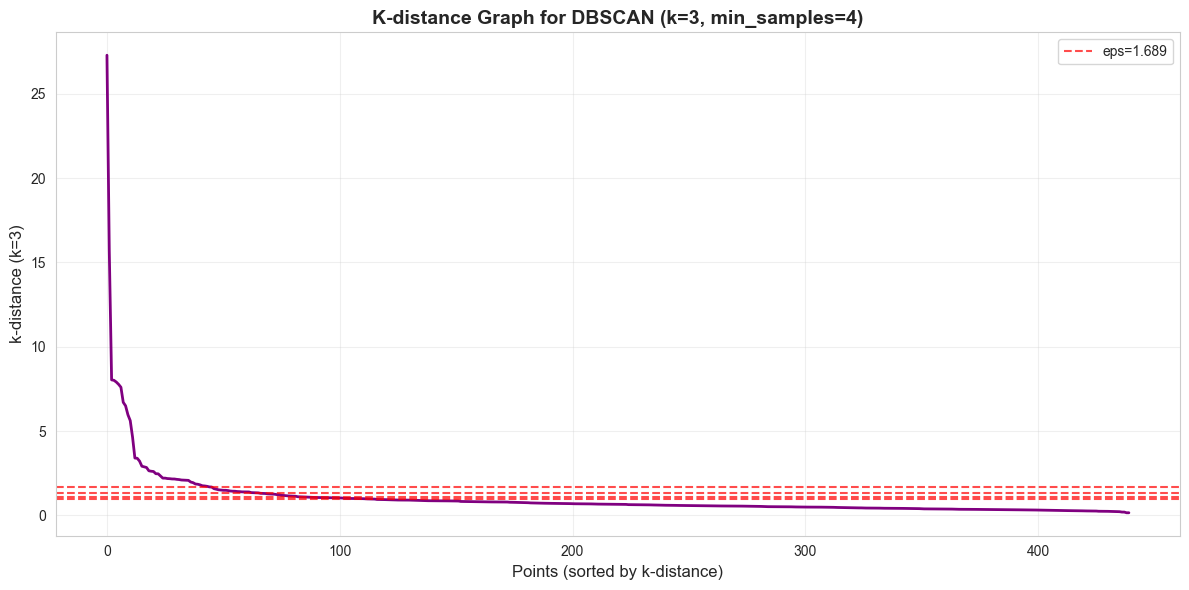

K-distance statistics (k=3):
  Min: 0.1513
  Max: 27.2875
  Mean: 1.0208
  Median: 0.6512

Suggested eps values (percentiles):
  90th percentile: 1.6893
  85th percentile: 1.3076
  80th percentile: 1.0674
  75th percentile: 0.9877


In [48]:
# DBSCAN: Compute k-distance plot to choose eps
min_samples = 4  # 4th nearest neighbor
k_for_distance = min_samples - 1

# Compute k-distance efficiently
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors.fit(X_cluster)
distances, _ = neighbors.kneighbors(X_cluster)
k_distances = distances[:, -1]  # Distance to k-th nearest neighbor
k_distances_sorted = np.sort(k_distances)[::-1]

# Plot k-distance graph
plt.figure(figsize=(12, 6))
plt.plot(k_distances_sorted, linewidth=2, color='purple')
plt.xlabel('Points (sorted by k-distance)', fontsize=12)
plt.ylabel(f'k-distance (k={k_for_distance})', fontsize=12)
plt.title(f'K-distance Graph for DBSCAN (k={k_for_distance}, min_samples={min_samples})', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Suggest eps values using percentiles
percentiles = [90, 85, 80, 75]
eps_suggestions = [np.percentile(k_distances_sorted, p) for p in percentiles]

for eps in eps_suggestions:
    plt.axhline(y=eps, color='red', linestyle='--', alpha=0.7, 
                label=f'eps={eps:.3f}' if eps == eps_suggestions[0] else '')
plt.legend()
plt.tight_layout()
plt.show()

# Display statistics
stats_dict = {
    'Min': k_distances_sorted.min(),
    'Max': k_distances_sorted.max(),
    'Mean': k_distances_sorted.mean(),
    'Median': np.median(k_distances_sorted)
}

print(f"K-distance statistics (k={k_for_distance}):")
for stat_name, stat_val in stats_dict.items():
    print(f"  {stat_name}: {stat_val:.4f}")
print(f"\nSuggested eps values (percentiles):")
for p, eps in zip(percentiles, eps_suggestions):
    print(f"  {p}th percentile: {eps:.4f}")


In [51]:
# Run DBSCAN for multiple parameter combinations
eps_values = [0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 2.5]
min_samples_values = [3, 4, 5, 6]

print("DBSCAN Results for Different Parameters:")
print("_"*80)
print(f"{'eps':<8} {'min_samples':<12} {'n_clusters':<12} {'n_noise':<12} {'% noise':<10}")
print("-"*80)

dbscan_results = []
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_cluster)
        
        unique_labels = np.unique(labels)
        n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
        n_noise = np.sum(labels == -1)
        noise_pct = (n_noise / len(labels)) * 100
        
        dbscan_results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_pct': noise_pct,
            'labels': labels
        })
        
        print(f"{eps:<8.2f} {min_samples:<12} {n_clusters:<12} {n_noise:<12} {noise_pct:<10.2f}")

print("_"*80)


DBSCAN Results for Different Parameters:
________________________________________________________________________________
eps      min_samples  n_clusters   n_noise      % noise   
--------------------------------------------------------------------------------
0.50     3            7            231          52.50     
0.50     4            6            247          56.14     
0.50     5            4            268          60.91     
0.50     6            1            294          66.82     
0.75     3            6            132          30.00     
0.75     4            1            155          35.23     
0.75     5            2            159          36.14     
0.75     6            2            166          37.73     
1.00     3            3            77           17.50     
1.00     4            2            81           18.41     
1.00     5            1            88           20.00     
1.00     6            1            93           21.14     
1.25     3            1       

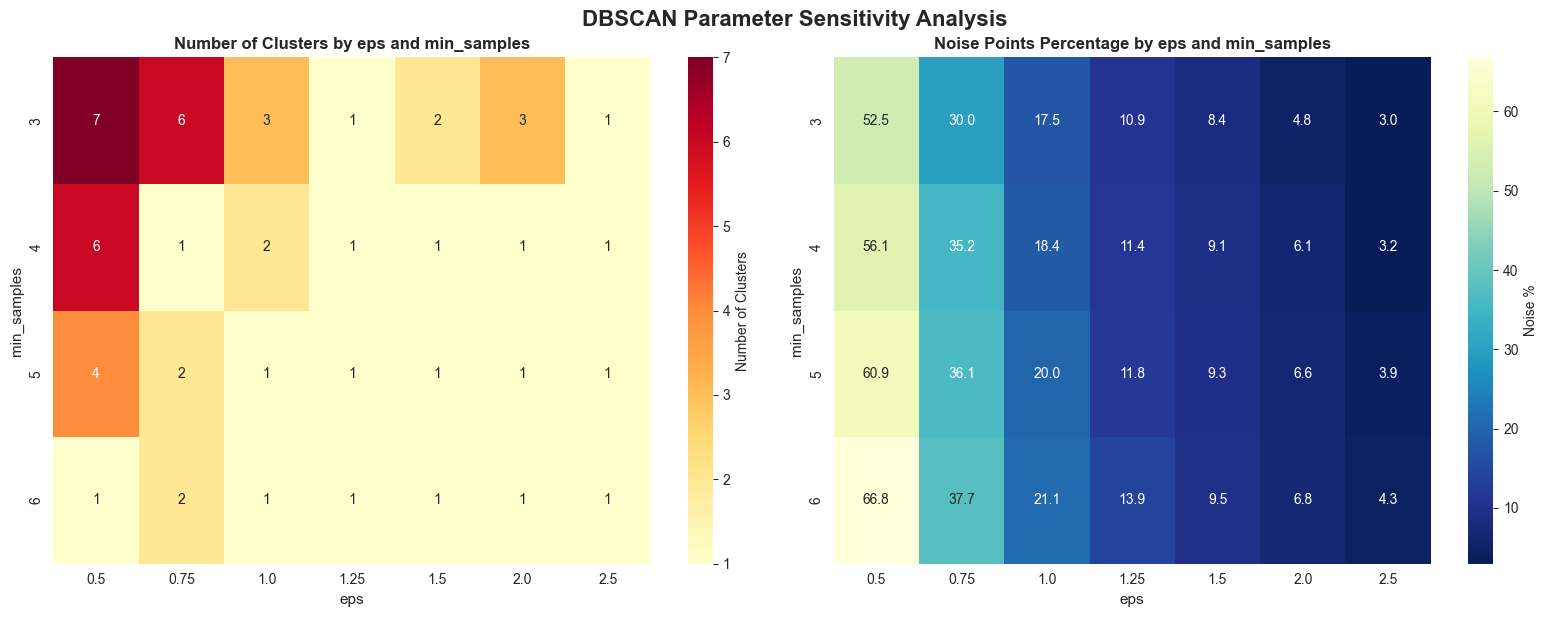


✓ Selected DBSCAN parameters:
  eps = 1.5
  min_samples = 3
  Expected clusters: 2
  Expected noise: 37 points (8.41%)

DBSCAN clustering complete
Cluster distribution:
DBSCAN_Cluster
-1     37
 0    400
 1      3
Name: count, dtype: int64


In [52]:
# Visualize DBSCAN parameter sensitivity
results_df = pd.DataFrame(dbscan_results)
pivot_clusters = results_df.pivot(index='min_samples', columns='eps', values='n_clusters')
pivot_noise = results_df.pivot(index='min_samples', columns='eps', values='noise_pct')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(pivot_clusters, annot=True, fmt='d', cmap='YlOrRd', ax=axes[0], 
            cbar_kws={'label': 'Number of Clusters'})
axes[0].set_title('Number of Clusters by eps and min_samples', fontweight='bold', fontsize=12)
axes[0].set_xlabel('eps', fontsize=11)
axes[0].set_ylabel('min_samples', fontsize=11)

sns.heatmap(pivot_noise, annot=True, fmt='.1f', cmap='YlGnBu_r', ax=axes[1], 
            cbar_kws={'label': 'Noise %'})
axes[1].set_title('Noise Points Percentage by eps and min_samples', fontweight='bold', fontsize=12)
axes[1].set_xlabel('eps', fontsize=11)
axes[1].set_ylabel('min_samples', fontsize=11)

plt.tight_layout()
plt.suptitle('DBSCAN Parameter Sensitivity Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Select optimal DBSCAN parameters
reasonable_configs = results_df[
    (results_df['n_clusters'].between(2, 8)) & 
    (results_df['noise_pct'] < 30)
]

if len(reasonable_configs) > 0:
    # Prefer moderate noise (5-15%)
    best_config = reasonable_configs[
        reasonable_configs['noise_pct'].between(5, 15)
    ]
    selected = best_config.iloc[0] if len(best_config) > 0 else reasonable_configs.iloc[0]
    
    optimal_eps = selected['eps']
    optimal_min_samples = int(selected['min_samples'])
    
    print(f"\n✓ Selected DBSCAN parameters:")
    print(f"  eps = {optimal_eps}")
    print(f"  min_samples = {optimal_min_samples}")
    print(f"  Expected clusters: {int(selected['n_clusters'])}")
    print(f"  Expected noise: {int(selected['n_noise'])} points ({selected['noise_pct']:.2f}%)")
    
    # Fit final DBSCAN model
    final_dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
    df_features['DBSCAN_Cluster'] = final_dbscan.fit_predict(X_cluster)
    
    print(f"\nDBSCAN clustering complete")
    cluster_counts = df_features['DBSCAN_Cluster'].value_counts().sort_index()
    print(f"Cluster distribution:\n{cluster_counts}")
else:
    print("\nWarning: No reasonable configuration found. Using default parameters.")
    optimal_eps, optimal_min_samples = 1.0, 4
    final_dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
    df_features['DBSCAN_Cluster'] = final_dbscan.fit_predict(X_cluster)


## Part E: Second EDA & Statistical Inference


In [54]:
# Tabulate K-means cluster centroids (in original units)
print("K-means Cluster Centroids (Original Units):")
print("_"*80)

centroids_original = pd.DataFrame(
    scaler.inverse_transform(final_kmeans.cluster_centers_),
    columns=SPENDING_COLS,
    index=[f'Cluster {i}' for i in range(optimal_k)]
)
centroids_original['Size'] = df_features['KMeans_Cluster'].value_counts().sort_index().values

print(centroids_original.round(2))
print(f"\nCluster sizes:\n{df_features['KMeans_Cluster'].value_counts().sort_index()}")


K-means Cluster Centroids (Original Units):
________________________________________________________________________________
             Fresh      Milk   Grocery    Frozen  Detergents_Paper  \
Cluster 0  11943.7   5709.36   7923.44   2995.71           2887.51   
Cluster 1  36847.0  43950.00  20170.00  36534.00            239.00   

           Delicassen  Size  
Cluster 0     1419.13   439  
Cluster 1    47943.00     1  

Cluster sizes:
KMeans_Cluster
0    439
1      1
Name: count, dtype: int64


In [55]:
# Tabulate DBSCAN cluster medoids (in original units)
print("\nDBSCAN Cluster Medoids (Original Units):")
print("_"*80)

dbscan_clusters = sorted([c for c in df_features['DBSCAN_Cluster'].unique() if c != -1])
if len(dbscan_clusters) > 0:
    medoids_list = []
    
    for cluster_id in dbscan_clusters:
        cluster_mask = df_features['DBSCAN_Cluster'] == cluster_id
        cluster_data = X_cluster[cluster_mask]
        
        if len(cluster_data) > 0:
            # Find medoid (point closest to centroid)
            centroid = cluster_data.mean(axis=0)
            distances = cdist([centroid], cluster_data)[0]
            medoid_idx = np.argmin(distances)
            medoid_original = scaler.inverse_transform([cluster_data[medoid_idx]])[0]
            medoids_list.append(medoid_original)
    
    if medoids_list:
        medoids_df = pd.DataFrame(medoids_list, columns=SPENDING_COLS,
                                  index=[f'Cluster {i}' for i in dbscan_clusters])
        medoids_df['Size'] = [np.sum(df_features['DBSCAN_Cluster'] == c) 
                             for c in dbscan_clusters]
        print(medoids_df.round(2))
        
        dbscan_counts = df_features['DBSCAN_Cluster'].value_counts().sort_index()
        print(f"\nCluster sizes:\n{dbscan_counts}")
        if -1 in dbscan_counts.index:
            print(f"\nNoise points: {dbscan_counts[-1]}")
else:
    print("No clusters found (all points marked as noise)")



DBSCAN Cluster Medoids (Original Units):
________________________________________________________________________________
            Fresh     Milk  Grocery  Frozen  Detergents_Paper  Delicassen  \
Cluster 0  8257.0   3880.0   6407.0  1646.0            2730.0       344.0   
Cluster 1  5181.0  22044.0  21531.0  1740.0            7353.0      4985.0   

           Size  
Cluster 0   400  
Cluster 1     3  

Cluster sizes:
DBSCAN_Cluster
-1     37
 0    400
 1      3
Name: count, dtype: int64

Noise points: 37


In [56]:
# Helper function for statistical tests
def test_cluster_differences(df, cluster_col, value_col, cluster_name):
    """Test if clusters show significant differences in a continuous variable."""
    clusters = sorted(df[cluster_col].unique())
    groups = [df[df[cluster_col] == c][value_col].values for c in clusters]
    
    print(f"\n{cluster_name}:")
    print("-"*70)
    
    # Normality check
    print("Normality check (Shapiro-Wilk test):")
    for cluster_id, group in zip(clusters, groups):
        _, p_val = stats.shapiro(group)
        status = "✓ Normal" if p_val > 0.05 else "✗ Not normal"
        print(f"  Cluster {cluster_id}: p-value = {p_val:.4f} ({status})")
    
    # ANOVA
    f_stat, p_anova = stats.f_oneway(*groups)
    print(f"\nANOVA Test:")
    print(f"  F-statistic: {f_stat:.4f}, p-value: {p_anova:.4f}")
    print(f"  Result: {'Significant difference' if p_anova < 0.05 else 'No significant difference'} (α=0.05)")
    
    # Kruskal-Wallis (non-parametric)
    h_stat, p_kruskal = kruskal(*groups)
    print(f"\nKruskal-Wallis Test (non-parametric):")
    print(f"  H-statistic: {h_stat:.4f}, p-value: {p_kruskal:.4f}")
    print(f"  Result: {'Significant difference' if p_kruskal < 0.05 else 'No significant difference'} (α=0.05)")

# Test TotalSpend differences
print("Statistical Test: Differences in TotalSpend across Clusters")
print("_"*70)

# K-means clusters
test_cluster_differences(df_features, 'KMeans_Cluster', 'TotalSpend', '1. K-means Clusters')

# DBSCAN clusters
dbscan_clusters_valid = [c for c in df_features['DBSCAN_Cluster'].unique() if c != -1]
if len(dbscan_clusters_valid) > 1:
    test_cluster_differences(df_features, 'DBSCAN_Cluster', 'TotalSpend', '2. DBSCAN Clusters')
else:
    print("\n2. DBSCAN Clusters:")
    print("-"*70)
    print("Insufficient clusters for statistical test (need at least 2 clusters)")


Statistical Test: Differences in TotalSpend across Clusters
______________________________________________________________________

1. K-means Clusters:
----------------------------------------------------------------------
Normality check (Shapiro-Wilk test):
  Cluster 0: p-value = 0.0000 (✗ Not normal)
  Cluster 1: p-value = nan (✗ Not normal)

ANOVA Test:
  F-statistic: 36.2272, p-value: 0.0000
  Result: Significant difference (α=0.05)

Kruskal-Wallis Test (non-parametric):
  H-statistic: 2.9053, p-value: 0.0883
  Result: No significant difference (α=0.05)

2. DBSCAN Clusters:
----------------------------------------------------------------------
Normality check (Shapiro-Wilk test):
  Cluster -1: p-value = 0.0008 (✗ Not normal)
  Cluster 0: p-value = 0.0000 (✗ Not normal)
  Cluster 1: p-value = 0.6148 (✓ Normal)

ANOVA Test:
  F-statistic: 172.4279, p-value: 0.0000
  Result: Significant difference (α=0.05)

Kruskal-Wallis Test (non-parametric):
  H-statistic: 89.8614, p-value: 0.000

In [57]:
# Helper function for chi-square tests
def test_categorical_association(df, cluster_col, cat_col, test_name):
    """Test association between clusters and categorical variable using chi-square."""
    print(f"\n{test_name}:")
    print("-"*70)
    contingency = pd.crosstab(df[cluster_col], df[cat_col])
    print(contingency)
    
    if contingency.shape[0] > 1 and contingency.shape[1] > 1:
        chi2, p_val, dof, _ = stats.chi2_contingency(contingency)
        print(f"\nChi-square test:")
        print(f"  Chi-square statistic: {chi2:.4f}")
        print(f"  p-value: {p_val:.4f}")
        print(f"  Degrees of freedom: {dof}")
        result = 'Significant association' if p_val < 0.05 else 'No significant association'
        print(f"  Result: {result} (α=0.05)")
    else:
        print("\nCannot perform chi-square test (insufficient categories)")

# Test associations
print("\nAssociation Test: Region/Channel vs Clusters")
print("_"*70)

# K-means associations
test_categorical_association(df_features, 'KMeans_Cluster', 'Region', 
                            '1. K-means Clusters vs Region')
test_categorical_association(df_features, 'KMeans_Cluster', 'Channel', 
                            '2. K-means Clusters vs Channel')

# DBSCAN associations
test_categorical_association(df_features, 'DBSCAN_Cluster', 'Region', 
                            '3. DBSCAN Clusters vs Region')
test_categorical_association(df_features, 'DBSCAN_Cluster', 'Channel', 
                            '4. DBSCAN Clusters vs Channel')



Association Test: Region/Channel vs Clusters
______________________________________________________________________

1. K-means Clusters vs Region:
----------------------------------------------------------------------
Region           1   2    3
KMeans_Cluster             
0               77  47  315
1                0   0    1

Chi-square test:
  Chi-square statistic: 0.3933
  p-value: 0.8215
  Degrees of freedom: 2
  Result: No significant association (α=0.05)

2. K-means Clusters vs Channel:
----------------------------------------------------------------------
Channel           1    2
KMeans_Cluster          
0               297  142
1                 1    0

Chi-square test:
  Chi-square statistic: 0.0000
  p-value: 1.0000
  Degrees of freedom: 1
  Result: No significant association (α=0.05)

3. DBSCAN Clusters vs Region:
----------------------------------------------------------------------
Region           1   2    3
DBSCAN_Cluster             
-1               7   4   26
 0  

## Part F: Presentation & Reflection


PCA Explained Variance:
  PC1: 44.38%
  PC2: 30.25%
  Total: 74.63%


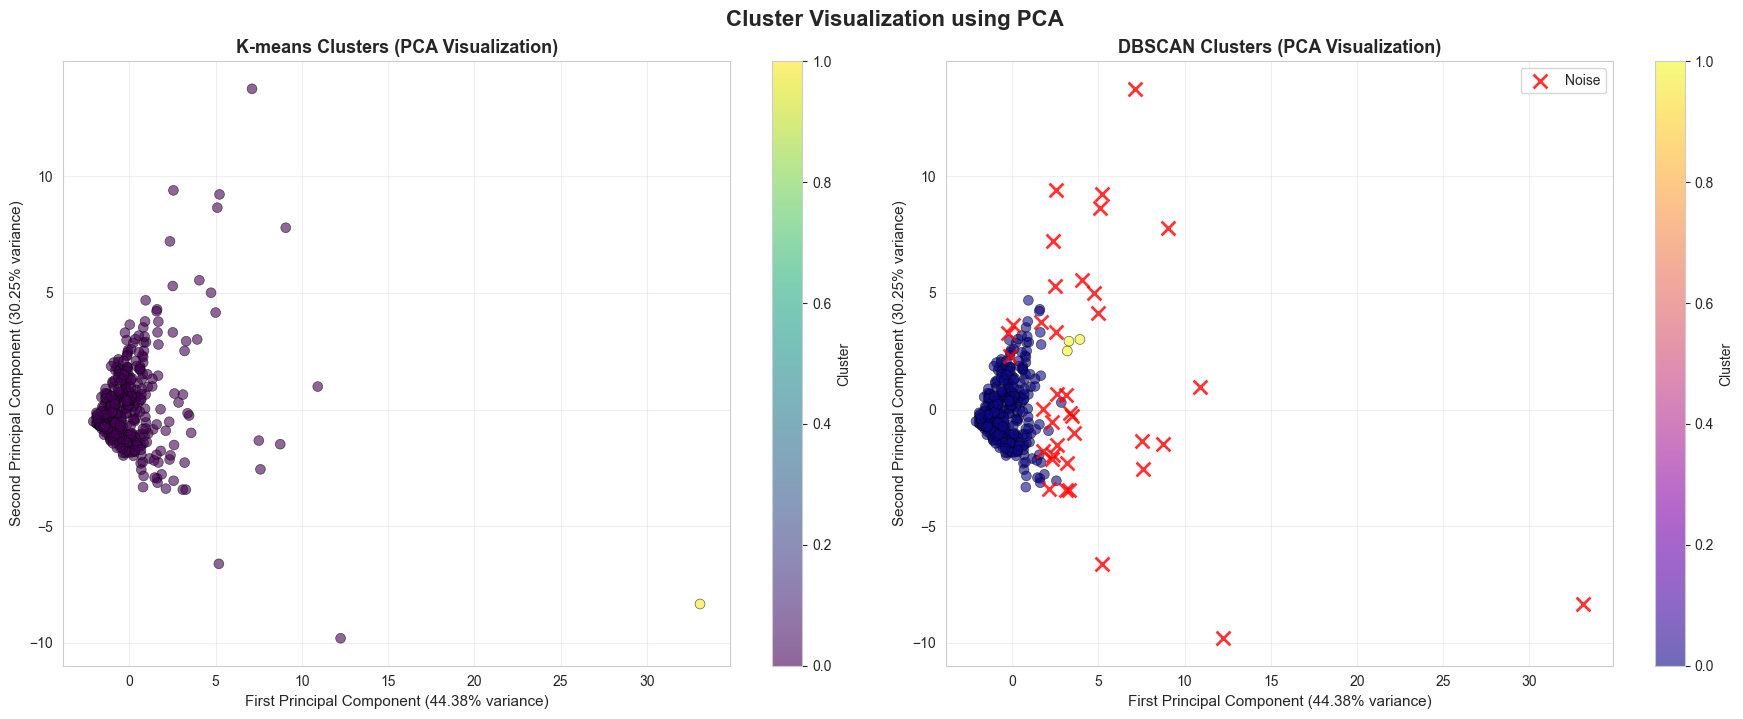


Noise points in DBSCAN: 37 (8.41%)


In [58]:
# Visualize clusters using PCA (2D)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_cluster)
explained_var = pca.explained_variance_ratio_

print("PCA Explained Variance:")
print(f"  PC1: {explained_var[0]:.2%}")
print(f"  PC2: {explained_var[1]:.2%}")
print(f"  Total: {explained_var.sum():.2%}")

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# K-means visualization
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=df_features['KMeans_Cluster'], 
                          cmap='viridis', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel(f'First Principal Component ({explained_var[0]:.2%} variance)', fontsize=11)
axes[0].set_ylabel(f'Second Principal Component ({explained_var[1]:.2%} variance)', fontsize=11)
axes[0].set_title('K-means Clusters (PCA Visualization)', fontweight='bold', fontsize=13)
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# DBSCAN visualization
noise_mask = df_features['DBSCAN_Cluster'] == -1
cluster_mask = ~noise_mask

if cluster_mask.sum() > 0:
    scatter2 = axes[1].scatter(X_pca[cluster_mask, 0], X_pca[cluster_mask, 1], 
                              c=df_features.loc[cluster_mask, 'DBSCAN_Cluster'], 
                              cmap='plasma', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
    plt.colorbar(scatter2, ax=axes[1], label='Cluster')

if noise_mask.sum() > 0:
    axes[1].scatter(X_pca[noise_mask, 0], X_pca[noise_mask, 1], 
                   c='red', marker='x', s=100, alpha=0.8, linewidths=2, label='Noise')
    axes[1].legend()

axes[1].set_xlabel(f'First Principal Component ({explained_var[0]:.2%} variance)', fontsize=11)
axes[1].set_ylabel(f'Second Principal Component ({explained_var[1]:.2%} variance)', fontsize=11)
axes[1].set_title('DBSCAN Clusters (PCA Visualization)', fontweight='bold', fontsize=13)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Cluster Visualization using PCA', fontsize=16, fontweight='bold', y=1.02)
plt.show()

noise_count = noise_mask.sum()
print(f"\nNoise points in DBSCAN: {noise_count} ({noise_count/len(df_features)*100:.2f}%)")


### Discussion: DBSCAN Sensitivity and K-means Assumptions


#### DBSCAN Sensitivity to Parameters:

1. **eps (ε) Parameter Sensitivity:**
   - **Small eps**: Creates many small clusters and marks many points as noise. Too restrictive.
   - **Large eps**: Merges distinct clusters into one large cluster. Too permissive.
   - **Optimal eps**: Found using k-distance plot, typically at the "knee" of the curve where the distance increases sharply.

2. **min_samples Parameter Sensitivity:**
   - **Small min_samples (e.g., 2-3)**: More sensitive to noise, creates many small clusters.
   - **Large min_samples (e.g., 6+)**: Requires denser regions, may miss smaller but valid clusters.
   - **Typical range**: 4-6 works well for most datasets.

3. **Key Observations from Our Analysis:**
   - DBSCAN is highly sensitive to both parameters, as shown in the heatmaps.
   - Small changes in eps can dramatically change the number of clusters and noise points.
   - The algorithm is excellent for identifying outliers (noise points) but requires careful parameter tuning.

#### K-means Assumptions:

1. **Spherical Clusters:**
   - K-means assumes clusters are spherical (circular in 2D) and have similar sizes.
   - This is a major limitation when clusters have irregular shapes or varying densities.
   - Our dataset may have non-spherical clusters, which could affect K-means performance.

2. **Equal Variance:**
   - Assumes clusters have similar variance/spread.
   - Violated when clusters have very different sizes or densities.

3. **Fixed Number of Clusters:**
   - Requires specifying k beforehand, which may not match the natural structure.
   - We used silhouette score and Davies-Bouldin index to select optimal k.

4. **Sensitivity to Initialization:**
   - Different random seeds can yield different results.
   - We used n_init=10 to mitigate this by running multiple initializations.

#### Comparison:

- **K-means**: Better for well-separated, spherical clusters of similar size. Fast and interpretable.
- **DBSCAN**: Better for irregularly shaped clusters and identifying outliers. No need to specify number of clusters.


### Domain Recommendations


In [60]:
# Helper function to print cluster profiles
def print_cluster_profile(df, cluster_col, cluster_id, spending_cols):
    """Print detailed profile for a single cluster."""
    cluster_data = df[df[cluster_col] == cluster_id]
    print(f"\nCluster {cluster_id} (n={len(cluster_data)}):")
    print(f"  Average TotalSpend: {cluster_data['TotalSpend'].mean():,.0f} m.u.")
    print(f"  Average ProportionFresh: {cluster_data['ProportionFresh'].mean():.3f}")
    
    # Top spending categories
    top_categories = cluster_data[spending_cols].mean().nlargest(3)
    print(f"  Top 3 spending categories:")
    for cat, val in top_categories.items():
        print(f"    {cat}: {val:,.0f} m.u.")
    
    # Channel distribution
    if 'Channel_label' in cluster_data.columns:
        channel_dist = cluster_data['Channel_label'].value_counts(normalize=True) * 100
        print(f"  Channel distribution:")
        for channel, pct in channel_dist.items():
            print(f"    {channel}: {pct:.1f}%")

# Analyze cluster characteristics for business recommendations
print("Cluster Analysis for Business Recommendations:")
print("_"*70)

# K-means cluster profiles
print("\nK-means Cluster Profiles:")
print("-"*70)
for cluster_id in sorted(df_features['KMeans_Cluster'].unique()):
    print_cluster_profile(df_features, 'KMeans_Cluster', cluster_id, SPENDING_COLS)

# DBSCAN cluster profiles
print("\n\nDBSCAN Cluster Profiles:")
print("-"*70)
dbscan_clusters_valid = sorted([c for c in df_features['DBSCAN_Cluster'].unique() if c != -1])
for cluster_id in dbscan_clusters_valid:
    print_cluster_profile(df_features, 'DBSCAN_Cluster', cluster_id, SPENDING_COLS)

# Noise points analysis
noise_data = df_features[df_features['DBSCAN_Cluster'] == -1]
if len(noise_data) > 0:
    print(f"\nNoise Points (n={len(noise_data)}):")
    print(f"  Average TotalSpend: {noise_data['TotalSpend'].mean():,.0f} m.u.")
    print(f"  These are outliers that don't fit into any cluster pattern.")


Cluster Analysis for Business Recommendations:
______________________________________________________________________

K-means Cluster Profiles:
----------------------------------------------------------------------

Cluster 0 (n=439):
  Average TotalSpend: 32,879 m.u.
  Average ProportionFresh: 0.375
  Top 3 spending categories:
    Fresh: 11,944 m.u.
    Grocery: 7,923 m.u.
    Milk: 5,709 m.u.
  Channel distribution:
    Horeca: 67.7%
    Retail: 32.3%

Cluster 1 (n=1):
  Average TotalSpend: 185,683 m.u.
  Average ProportionFresh: 0.198
  Top 3 spending categories:
    Delicassen: 47,943 m.u.
    Milk: 43,950 m.u.
    Fresh: 36,847 m.u.
  Channel distribution:
    Horeca: 100.0%


DBSCAN Cluster Profiles:
----------------------------------------------------------------------

Cluster 0 (n=400):
  Average TotalSpend: 27,738 m.u.
  Average ProportionFresh: 0.388
  Top 3 spending categories:
    Fresh: 10,964 m.u.
    Grocery: 6,454 m.u.
    Milk: 4,436 m.u.
  Channel distribution:
   

#### Business Recommendations:

1. **High-Value Customer Segments:**
   - Identify clusters with high TotalSpend and develop VIP programs or loyalty rewards.
   - Target these customers with premium products and personalized service.

2. **Product Mix Optimization:**
   - Clusters with high ProportionFresh indicate customers preferring fresh products.
   - Adjust inventory and supply chain for clusters with different product preferences.
   - Cross-selling opportunities based on co-purchasing patterns (e.g., Grocery-Milk correlation).

3. **Channel-Specific Strategies:**
   - If clusters show strong association with Channel (Horeca vs Retail):
     - Horeca customers: Focus on bulk orders, fresh products, and delivery services.
     - Retail customers: Emphasize convenience, variety, and competitive pricing.

4. **Regional Targeting:**
   - If clusters associate with Region, develop region-specific marketing campaigns.
   - Adjust product mix based on regional preferences (Lisbon, Oporto, Other).

5. **Outlier Management (DBSCAN Noise Points):**
   - Investigate noise points individually - they may be:
     - High-value customers with unique purchasing patterns (opportunity for customization)
     - Anomalies requiring investigation (fraud, data errors)
     - Emerging customer segments that need separate strategies

6. **Promotional Strategies:**
   - Low-spend, high-frequency clusters: Volume discounts to increase basket size.
   - High-spend, low-frequency clusters: Retention campaigns to maintain loyalty.
   - Seasonal promotions aligned with cluster purchasing patterns.

7. **Inventory Management:**
   - Use cluster centroids to predict demand for each product category.
   - Optimize stock levels based on cluster sizes and spending patterns.
   - Plan for seasonal variations by cluster.

8. **Customer Acquisition:**
   - Identify characteristics of high-value clusters.
   - Target similar customers in marketing campaigns.
   - Develop referral programs within high-value clusters.


## Summary

This analysis compared K-means and DBSCAN clustering algorithms on the UCI Wholesale Customers Dataset. Key findings:

- **Data Quality**: No missing values, minimal duplicates removed.
- **Feature Engineering**: Created TotalSpend, ProportionFresh, and LogTotalSpend to capture customer behavior.
- **K-means**: Selected optimal k based on silhouette score and Davies-Bouldin index.
- **DBSCAN**: Tuned eps and min_samples parameters using k-distance plots and sensitivity analysis.
- **Statistical Validation**: Confirmed significant differences in TotalSpend across clusters and associations with Channel/Region.
- **Visualization**: Used PCA to visualize clusters in 2D space, highlighting DBSCAN noise points.

Both algorithms provide valuable insights for customer segmentation, with K-means offering interpretable spherical clusters and DBSCAN identifying irregular patterns and outliers.
